In [1]:
import os

os.chdir("..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm.auto import tqdm
import warnings

# Evaluation
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
    make_scorer
)

# tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

# Stratified sampling for multi-label classification
from skmultilearn.model_selection import IterativeStratification

# Other
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Classifiers
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

from src.models.evaluation import evaluation

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
pd.set_option("display.max_rows", 5)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 100)

## 1. Load and transform data

In [4]:
# Load data
df = pd.read_pickle("data/processed/reports_tokenized.p")
df

,ID,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17,CSR_Filename,CSR_Text_clean,CSR_Text_tokenized
0,0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False,0_888.L_2020.pdf,888 ORG ANNUAL REPORT & ACCOUNTS 2020 A YEAR OF STRONG GROWTH 888 IS ONE OF THE WORLDS LEADING O...,org annual report account year strong growth one world leading online betting gaming company org...
1,1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,True,True,False,1_A.N_2020.pdf,Delivering on our Promises 2020 Corporate ORG 1 Letter from the President Stakeholder engagement...,delivering promise corporate org letter president stakeholder engagement environment table conte...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8139,12676,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,False,NaN,False,True,False,12676_ZBH.N_2016.pdf,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2016 T A B L E O...,e n v r n e n l c l g v e r n n c e sustainability report b l e f c n e n company profile corpor...
8140,12677,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,False,True,True,False,True,True,False,False,NaN,False,True,False,NaN,False,False,False,12677_ZBH.N_2015.pdf,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2015 Investing n...,e n v r n e n l c l g v e r n n c e sustainability report investing future world b l e f c n e n...


In [5]:
# Transform labels to numpy array: Exclude SDGs 2 and 9 (too few aligned examples) and 10 and 14 (no mapping) -> 13 labels left
labels = [
    "SDG_1",
    "SDG_3",
    "SDG_4",
    "SDG_5",
    "SDG_6",
    "SDG_7",
    "SDG_8",
    "SDG_11",
    "SDG_12",
    "SDG_13",
    "SDG_15",
    "SDG_16",
    "SDG_17",
]
Y = df[labels].to_numpy().astype(int)

In [6]:
# Split into 80% training and 20% test data (stratified for multi-label, adapted to work with df column)

np.random.seed(7)

def iterative_train_test_split(X, y, test_size):
    stratifier = IterativeStratification(n_splits=2, order=2, sample_distribution_per_fold=[test_size, 1.0-test_size])
    train_indexes, test_indexes = next(stratifier.split(X, y))

    X_train, y_train = X.iloc[train_indexes], y[train_indexes, :]
    X_test, y_test = X.iloc[test_indexes], y[test_indexes, :]

    return X_train, y_train, X_test, y_test

X_train, Y_train, X_test, Y_test = iterative_train_test_split(df['CSR_Text_tokenized'], Y, test_size=0.2)

## 2. Classification without prior balancing of the data

### Tests

In [37]:
# tfidf
tfidf = TfidfVectorizer(max_df=1.0, ngram_range=(1,2)) # ignore terms that appear in all documents and use unigrams and bigrams
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END ................................clf__estimator__C=1; total time=14.7min
[CV] END ................................clf__estimator__C=1; total time=15.3min
Best Parameters: {'clf__estimator__C': 1}
Mean cross-validated F1-score of the best estimator: 0.8545501056245037
              precision    recall  f1-score   support

           0       0.82      0.25      0.38       198
           1       0.80      1.00      0.89      1499
           2       0.77      1.00      0.87      1442
           3       0.73      0.99      0.84      1314
           4       0.80      0.98      0.88      1414
           5       0.78      0.95      0.86      1317
           6       0.72      0.98      0.83      1220
           7       0.84      0.24      0.37       191
           8       0.83      1.00      0.90      1544
           9       0.75      0.85      0.80      1151
          10       0.80      0.57      0.67       559
          11    

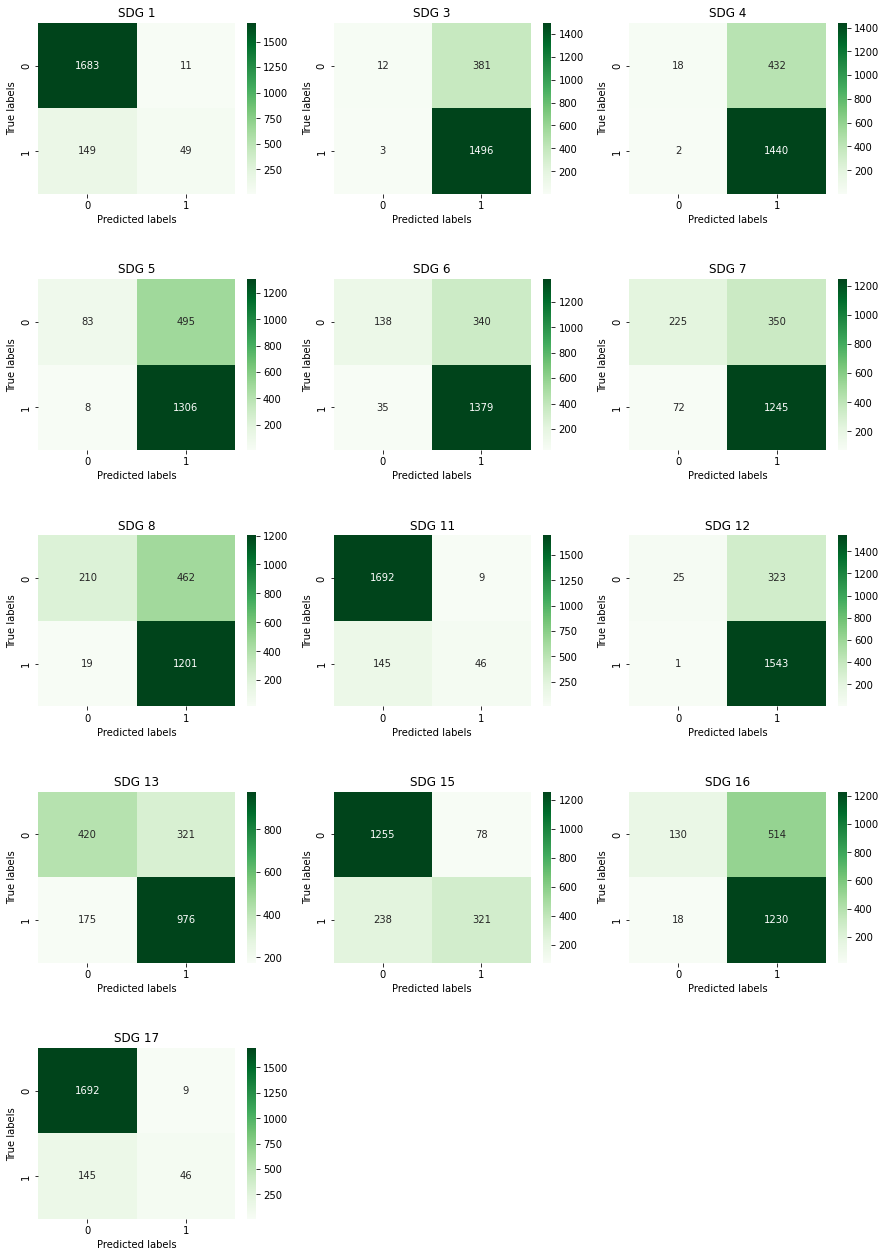

In [8]:
# Just F1 Score for positive class
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('clf', OneVsRestClassifier(LogisticRegression()))
])
    
# Parameters to test in Grid Search
parameters = {
    'clf__estimator__C': [1] # Inverse of regularization strength, smaller values specify stronger regularization
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=2, order=1)
# Optimize for weighted F1-score
scorer = make_scorer(f1_score, average="weighted")

# Grid Search
grid_lr = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=2)
grid_lr.fit(X_train_tfidf, Y_train)

# Print results
print("Best Parameters: {}".format(grid_lr.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_lr.best_score_))

evaluation(grid_lr, X_test_tfidf, Y_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END ................................clf__estimator__C=1; total time=13.3min
[CV] END ................................clf__estimator__C=1; total time=16.0min
Best Parameters: {'clf__estimator__C': 1}
Mean cross-validated F1-score of the best estimator: 0.8644111447875122
              precision    recall  f1-score   support

           0       0.60      0.73      0.66       198
           1       0.89      0.81      0.84      1499
           2       0.86      0.84      0.85      1442
           3       0.87      0.81      0.84      1314
           4       0.90      0.70      0.79      1414
           5       0.88      0.70      0.78      1317
           6       0.85      0.81      0.83      1220
           7       0.57      0.71      0.63       191
           8       0.92      0.75      0.83      1544
           9       0.84      0.68      0.75      1151
          10       0.73      0.73      0.73       559
          11    

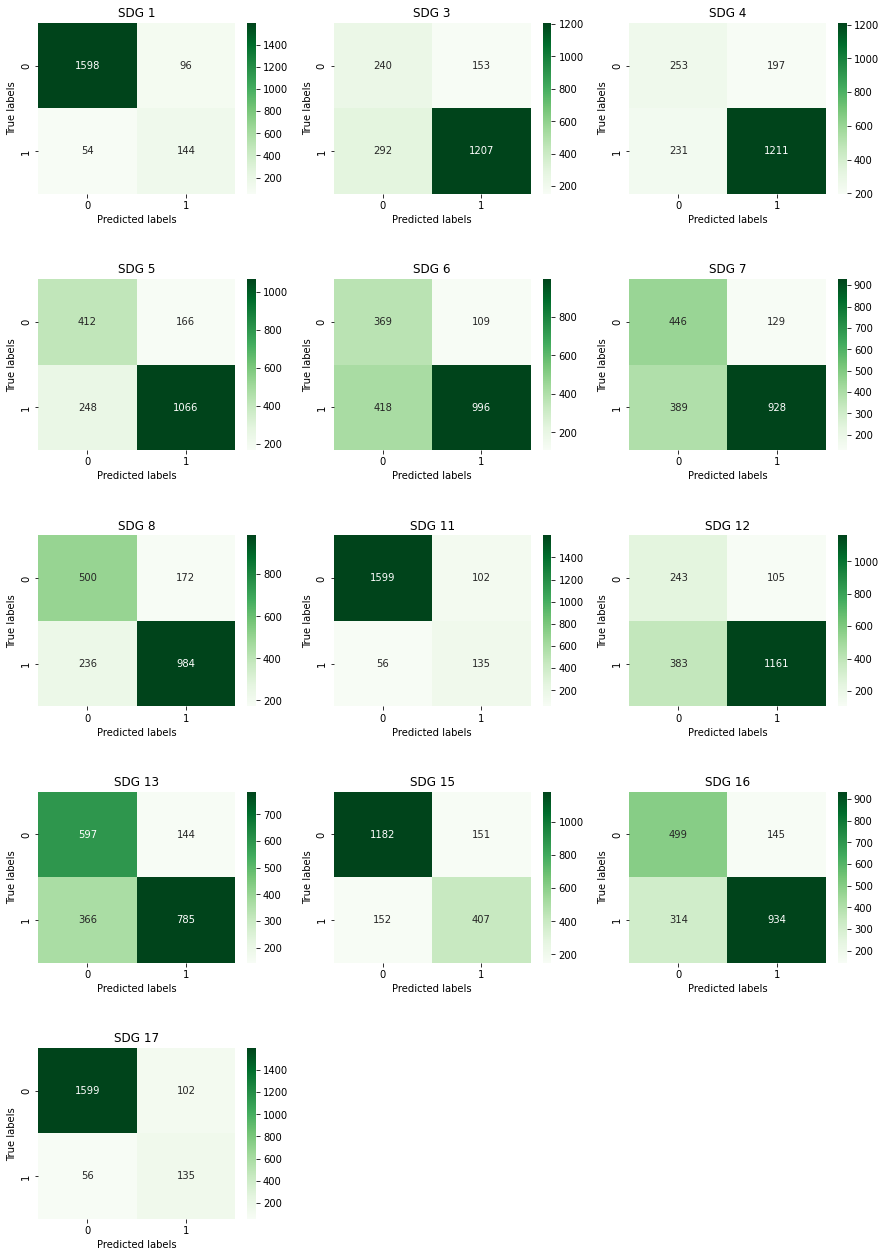

In [25]:
# Just F1 Score for positive class
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('clf', OneVsRestClassifier(LogisticRegression(class_weight="balanced")))
])
    
# Parameters to test in Grid Search
parameters = {
    'clf__estimator__C': [1] # Inverse of regularization strength, smaller values specify stronger regularization
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=2, order=1)
# Optimize for weighted F1-score
scorer = make_scorer(f1_score, average="weighted")

# Grid Search
grid_lr = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=2)
grid_lr.fit(X_train_tfidf, Y_train)

# Print results
print("Best Parameters: {}".format(grid_lr.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_lr.best_score_))

evaluation(grid_lr, X_test_tfidf, Y_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END ................................clf__estimator__C=1; total time=15.4min
[CV] END ................................clf__estimator__C=1; total time=16.8min
Best Parameters: {'clf__estimator__C': 1}
Mean cross-validated F1-score of the best estimator: 0.7232582421999283
              precision    recall  f1-score   support

           0       0.82      0.25      0.38       198
           1       0.80      1.00      0.89      1499
           2       0.77      1.00      0.87      1442
           3       0.73      0.99      0.84      1314
           4       0.80      0.98      0.88      1414
           5       0.78      0.95      0.86      1317
           6       0.72      0.98      0.83      1220
           7       0.84      0.24      0.37       191
           8       0.83      1.00      0.90      1544
           9       0.75      0.85      0.80      1151
          10       0.80      0.57      0.67       559
          11    

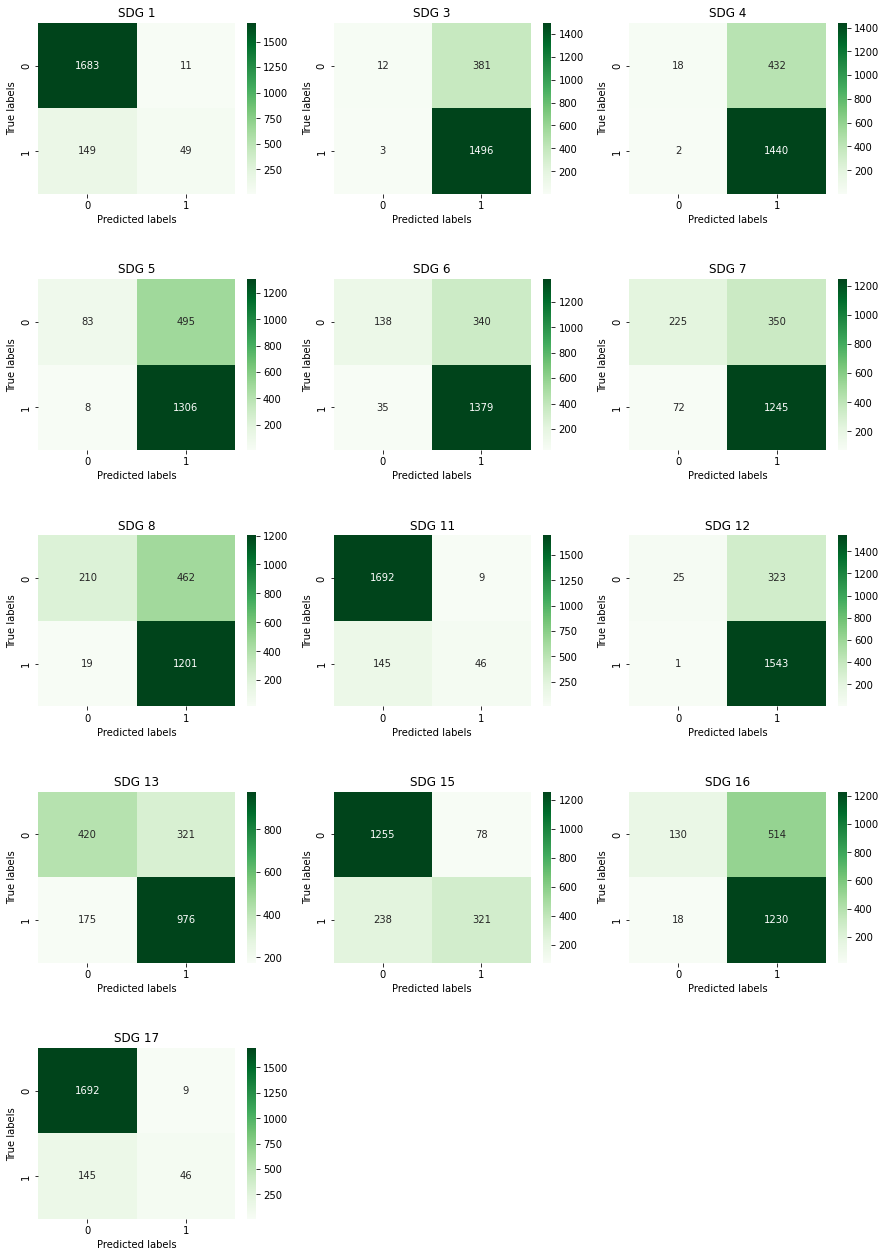

In [23]:
# Just F1 Score for positive class
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('clf', OneVsRestClassifier(LogisticRegression()))
])
    
# Parameters to test in Grid Search
parameters = {
    'clf__estimator__C': [1] # Inverse of regularization strength, smaller values specify stronger regularization
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=2, order=1)
# Optimize for weighted F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_lr = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=2)
grid_lr.fit(X_train_tfidf, Y_train)

# Print results
print("Best Parameters: {}".format(grid_lr.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_lr.best_score_))

evaluation(grid_lr, X_test_tfidf, Y_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 2/2] END ...............clf__estimator__C=1;, score=0.824 total time=14.1min
[CV 1/2] END ...............clf__estimator__C=1;, score=0.824 total time=14.1min
Best Parameters: {'clf__estimator__C': 1}
Mean cross-validated F1-score of the best estimator: 0.8243213647823954
              precision    recall  f1-score   support

           0       0.60      0.73      0.66       198
           1       0.89      0.81      0.84      1499
           2       0.86      0.84      0.85      1442
           3       0.87      0.81      0.84      1314
           4       0.90      0.70      0.79      1414
           5       0.88      0.70      0.78      1317
           6       0.85      0.81      0.83      1220
           7       0.57      0.71      0.63       191
           8       0.92      0.75      0.83      1544
           9       0.84      0.68      0.75      1151
          10       0.73      0.73      0.73       559
          11    

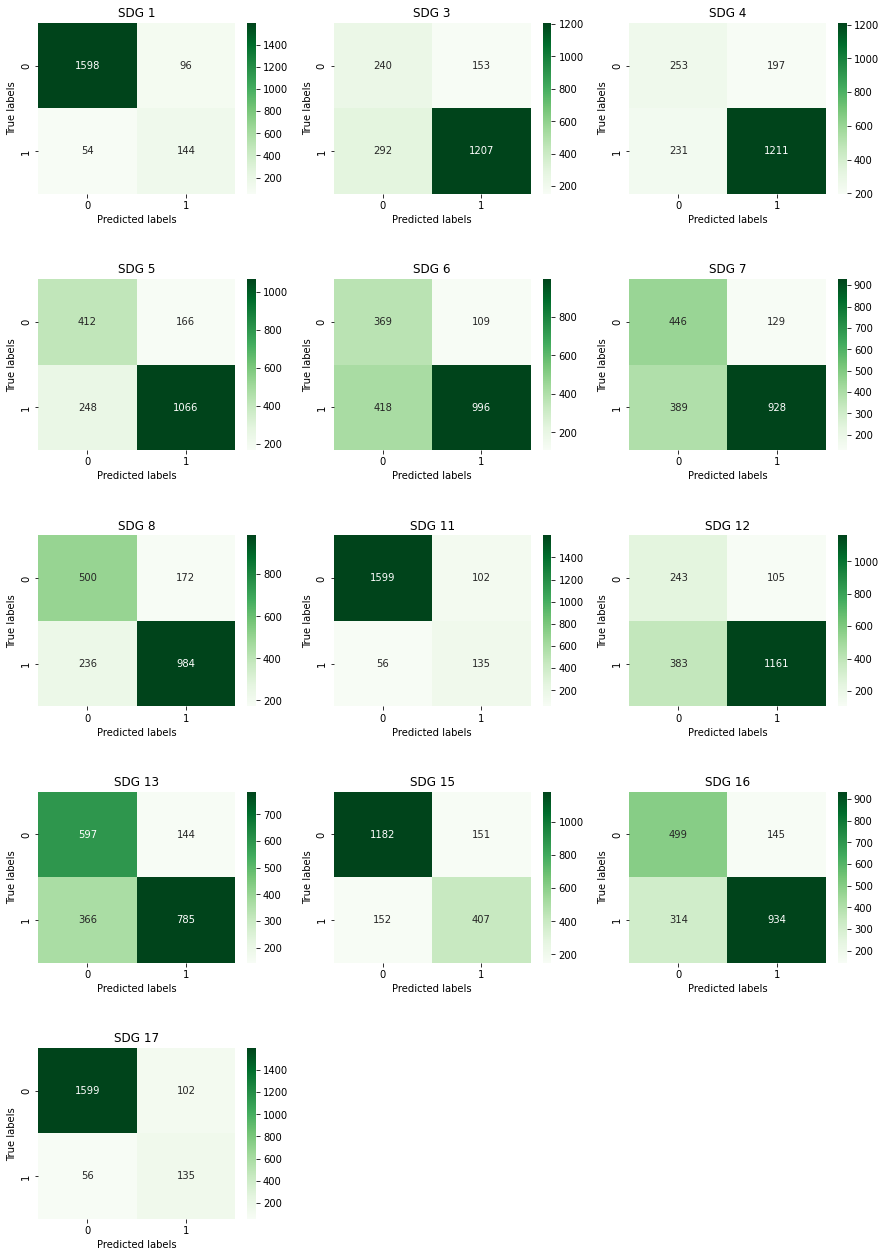

In [26]:
# Just F1 Score for positive class
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('clf', OneVsRestClassifier(LogisticRegression(class_weight="balanced")))
])
    
# Parameters to test in Grid Search
parameters = {
    'clf__estimator__C': [1] # Inverse of regularization strength, smaller values specify stronger regularization
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=2, order=1)
# Optimize for weighted F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_lr = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_lr.fit(X_train_tfidf, Y_train)

# Print results
print("Best Parameters: {}".format(grid_lr.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_lr.best_score_))

evaluation(grid_lr, X_test_tfidf, Y_test)

In [27]:
predictions = grid_lr.predict(X_test_tfidf)

In [33]:
for i in range(13):
    print(f1_score(predictions[:,i], Y_test[:,i], average='weighted'))

0.9174152440656578
0.7528448511781438
0.7710162962807645
0.7774609432377309
0.7045233210776698
0.7159655192306874
0.7823584684049801
0.9125751493154134
0.718021559887463
0.7272698283128598
0.8398936711181576
0.7521392642445431
0.9125751493154134


### 2.1. Logistic Regression

In [7]:
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))), # Use unigrams and bigrams
    ('clf', OneVsRestClassifier(LogisticRegression()))
])
    
# Parameters to test in Grid Search
parameters = {
    'tfidf__min_df': [2, 5], # Ignore terms that appear in less than 2/ 5 of the documents
    'tfidf__max_df': [0.9, 1.0], # Ignore terms that appear in more than 90%/ 100% of the documents
    'clf__estimator__C': [0.1, 1, 10] # Inverse of regularization strength, smaller values specify stronger regularization
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for weighted F1-score
scorer = make_scorer(f1_score, average="weighted")

# Grid Search
grid_lr = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=16, verbose=2)
grid_lr.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_lr.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_lr.best_score_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END clf__estimator__C=0.1, tfidf__max_df=0.9, tfidf__min_df=2; total time=14.4min
[CV] END clf__estimator__C=1, tfidf__max_df=0.9, tfidf__min_df=2; total time=30.3min
[CV] END clf__estimator__C=0.1, tfidf__max_df=0.9, tfidf__min_df=2; total time=14.5min
[CV] END clf__estimator__C=1, tfidf__max_df=0.9, tfidf__min_df=2; total time=31.1min
[CV] END clf__estimator__C=0.1, tfidf__max_df=1.0, tfidf__min_df=2; total time=15.5min
[CV] END clf__estimator__C=1, tfidf__max_df=1.0, tfidf__min_df=2; total time=32.9min
[CV] END clf__estimator__C=10, tfidf__max_df=0.9, tfidf__min_df=5; total time=39.7min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV] END clf__estimator__C=0.1, tfidf__max_df=1.0, tfidf__min_df=2; total time=14.4min
[CV] END clf__estimator__C=1, tfidf__max_df=0.9, tfidf__min_df=2; total time=27.6min
[CV] END clf__estimator__C=10, tfidf__max_df=0.9, tfidf__min_df=2; total time=47.4min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV] END clf__estimator__C=0.1, tfidf__max_df=0.9, tfidf__min_df=2; total time=15.0min
[CV] END clf__estimator__C=1, tfidf__max_df=0.9, tfidf__min_df=5; total time=20.6min
[CV] END clf__estimator__C=10, tfidf__max_df=0.9, tfidf__min_df=2; total time=58.0min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV] END clf__estimator__C=0.1, tfidf__max_df=0.9, tfidf__min_df=5; total time=10.5min
[CV] END clf__estimator__C=1, tfidf__max_df=0.9, tfidf__min_df=2; total time=27.7min
[CV] END clf__estimator__C=10, tfidf__max_df=0.9, tfidf__min_df=2; total time=56.1min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV] END clf__estimator__C=0.1, tfidf__max_df=1.0, tfidf__min_df=2; total time=14.6min
[CV] END clf__estimator__C=1, tfidf__max_df=0.9, tfidf__min_df=5; total time=18.1min
[CV] END clf__estimator__C=1, tfidf__max_df=1.0, tfidf__min_df=5; total time=17.5min
[CV] END clf__estimator__C=10, tfidf__max_df=1.0, tfidf__min_df=2; total time=46.9min
[CV] END clf__estimator__C=0.1, tfidf__max_df=0.9, tfidf__min_df=5; total time=10.1min
[CV] END clf__estimator__C=0.1, tfidf__max_df=1.0, tfidf__min_df=5; total time=10.7min
[CV] END clf__estimator__C=1, tfidf__max_df=1.0, tfidf__min_df=5; total time=21.8min
[CV] END clf__estimator__C=10, tfidf__max_df=0.9, tfidf__min_df=2; total time=57.0min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV] END clf__estimator__C=0.1, tfidf__max_df=1.0, tfidf__min_df=2; total time=15.2min
[CV] END clf__estimator__C=1, tfidf__max_df=0.9, tfidf__min_df=5; total time=18.8min
[CV] END clf__estimator__C=1, tfidf__max_df=1.0, tfidf__min_df=5; total time=15.6min
[CV] END clf__estimator__C=10, tfidf__max_df=1.0, tfidf__min_df=2; total time=52.4min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV] END clf__estimator__C=0.1, tfidf__max_df=0.9, tfidf__min_df=2; total time=15.0min
[CV] END clf__estimator__C=1, tfidf__max_df=0.9, tfidf__min_df=5; total time=17.3min
[CV] END clf__estimator__C=1, tfidf__max_df=1.0, tfidf__min_df=5; total time=23.6min
[CV] END clf__estimator__C=10, tfidf__max_df=1.0, tfidf__min_df=2; total time=46.4min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV] END clf__estimator__C=0.1, tfidf__max_df=0.9, tfidf__min_df=5; total time=10.1min
[CV] END clf__estimator__C=0.1, tfidf__max_df=1.0, tfidf__min_df=5; total time= 9.9min
[CV] END clf__estimator__C=1, tfidf__max_df=1.0, tfidf__min_df=2; total time=35.2min
[CV] END clf__estimator__C=10, tfidf__max_df=1.0, tfidf__min_df=2; total time=52.2min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV] END clf__estimator__C=0.1, tfidf__max_df=1.0, tfidf__min_df=5; total time= 9.8min
[CV] END clf__estimator__C=0.1, tfidf__max_df=1.0, tfidf__min_df=5; total time= 9.4min
[CV] END clf__estimator__C=1, tfidf__max_df=1.0, tfidf__min_df=2; total time=29.2min
[CV] END clf__estimator__C=10, tfidf__max_df=0.9, tfidf__min_df=5; total time=36.3min
[CV] END clf__estimator__C=10, tfidf__max_df=1.0, tfidf__min_df=5; total time=18.1min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV] END clf__estimator__C=10, tfidf__max_df=0.9, tfidf__min_df=5; total time=41.7min
[CV] END clf__estimator__C=10, tfidf__max_df=1.0, tfidf__min_df=5; total time=17.4min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV] END clf__estimator__C=0.1, tfidf__max_df=0.9, tfidf__min_df=5; total time= 9.3min
[CV] END clf__estimator__C=0.1, tfidf__max_df=1.0, tfidf__min_df=5; total time= 9.4min
[CV] END clf__estimator__C=1, tfidf__max_df=1.0, tfidf__min_df=2; total time=36.1min
[CV] END clf__estimator__C=10, tfidf__max_df=1.0, tfidf__min_df=2; total time=51.6min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV] END clf__estimator__C=0.1, tfidf__max_df=1.0, tfidf__min_df=2; total time=15.2min
[CV] END clf__estimator__C=1, tfidf__max_df=1.0, tfidf__min_df=2; total time=32.3min
[CV] END clf__estimator__C=10, tfidf__max_df=0.9, tfidf__min_df=5; total time=39.8min
[CV] END clf__estimator__C=10, tfidf__max_df=1.0, tfidf__min_df=5; total time=20.0min
[CV] END clf__estimator__C=10, tfidf__max_df=0.9, tfidf__min_df=5; total time=41.4min
[CV] END clf__estimator__C=10, tfidf__max_df=1.0, tfidf__min_df=5; total time=21.8min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Best Parameters: {'clf__estimator__C': 10, 'tfidf__max_df': 0.9, 'tfidf__min_df': 2}
Mean cross-validated F1-score of the best estimator: 0.9173939039534732


### 2.2. Linear SVM
Training takes very long due to high dimensionality of tf-idf vectors

In [ ]:
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))), # Use unigrams and bigrams
    ('clf', OneVsRestClassifier(SVC(kernel='linear')))
])
    
# Parameters to test in Grid Search
parameters = {
    'tfidf__min_df': [2, 5], # Ignore terms that appear in less than 2/ 5 of the documents
    'tfidf__max_df': [0.9, 1.0], # Ignore terms that appear in more than 90%/ 100% of the documents
    'clf__estimator__C': [0.1, 1, 10] # Inverse of regularization strength, smaller values specify stronger regularization
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for weighted F1-score
scorer = make_scorer(f1_score, average="weighted")

# Grid Search
grid_svm = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=16, verbose=2)
grid_svm.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_svm.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_svm.best_score_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END clf__estimator__C=0.1, tfidf__max_df=0.9, tfidf__min_df=5; total time=281.1min
[CV] END clf__estimator__C=0.1, tfidf__max_df=1.0, tfidf__min_df=5; total time=275.7min
[CV] END clf__estimator__C=0.1, tfidf__max_df=1.0, tfidf__min_df=5; total time=281.0min
[CV] END clf__estimator__C=0.1, tfidf__max_df=1.0, tfidf__min_df=5; total time=280.2min
[CV] END clf__estimator__C=0.1, tfidf__max_df=0.9, tfidf__min_df=5; total time=285.3min
[CV] END clf__estimator__C=0.1, tfidf__max_df=1.0, tfidf__min_df=5; total time=277.9min
[CV] END clf__estimator__C=0.1, tfidf__max_df=0.9, tfidf__min_df=5; total time=285.2min
[CV] END clf__estimator__C=0.1, tfidf__max_df=1.0, tfidf__min_df=5; total time=278.6min
[CV] END clf__estimator__C=0.1, tfidf__max_df=1.0, tfidf__min_df=2; total time=319.4min
[CV] END clf__estimator__C=1, tfidf__max_df=0.9, tfidf__min_df=5; total time=267.7min
[CV] END clf__estimator__C=0.1, tfidf__max_df=0.9, tfidf__min

### 2.3 KNN

In [ ]:
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))), # Use unigrams and bigrams
    ('clf', OneVsRestClassifier(KNeighborsClassifier()))
])
    
# Parameters to test in Grid Search
parameters = {
    'tfidf__min_df': [2, 5], # Ignore terms that appear in less than 2/ 5 of the documents
    'tfidf__max_df': [0.9, 1.0], # Ignore terms that appear in more than 90%/ 100% of the documents
    'clf__estimator__n_neighbors': [5, 15, 25, 55] # Number of neighbors
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for weighted F1-score
scorer = make_scorer(f1_score, average="weighted")

# Grid Search
grid_knn = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=16, verbose=2)
grid_knn.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_knn.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_knn.best_score_))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


### 2.4. Naive Bayes

In [ ]:
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))), # Use unigrams and bigrams
    ('clf', OneVsRestClassifier(MultinomialNB()))
])
    
# Parameters to test in Grid Search
parameters = {
    'tfidf__min_df': [2, 5], # Ignore terms that appear in less than 2/ 5 of the documents
    'tfidf__max_df': [0.9, 1.0], # Ignore terms that appear in more than 90%/ 100% of the documents
    'clf__estimator__alpha': [0.01, 0.1, 1] # Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing)
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for weighted F1-score
scorer = make_scorer(f1_score, average="weighted")

# Grid Search
grid_nb = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=16, verbose=2)
grid_nb.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_nb.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_nb.best_score_))

### 2.5. Random Forest

In [7]:
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))), # Use unigrams and bigrams
    ('clf', OneVsRestClassifier(RandomForestClassifier()))
])
    
# Parameters to test in Grid Search
parameters = {
    'tfidf__min_df': [2, 5], # Ignore terms that appear in less than 2/ 5 of the documents
    'tfidf__max_df': [0.9, 1.0], # Ignore terms that appear in more than 90%/ 100% of the documents
    'clf__estimator__n_estimators': [50, 100], # Number of trees in the forest
    'clf__estimator__max_depth': [10, 20, None] # Maximum depth of the tree
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for weighted F1-score
scorer = make_scorer(f1_score, average="weighted")

# Grid Search
grid_rf = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=16, verbose=2)
grid_rf.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_rf.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_rf.best_score_))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END clf__estimator__max_depth=10, clf__estimator__n_estimators=50, tfidf__max_df=0.9, tfidf__min_df=2; total time=30.4min
[CV] END clf__estimator__max_depth=10, clf__estimator__n_estimators=100, tfidf__max_df=0.9, tfidf__min_df=2; total time=21.2min
[CV] END clf__estimator__max_depth=20, clf__estimator__n_estimators=50, tfidf__max_df=0.9, tfidf__min_df=5; total time=17.7min
[CV] END clf__estimator__max_depth=20, clf__estimator__n_estimators=50, tfidf__max_df=1.0, tfidf__min_df=5; total time=13.0min
[CV] END clf__estimator__max_depth=20, clf__estimator__n_estimators=100, tfidf__max_df=1.0, tfidf__min_df=2; total time=21.8min
[CV] END clf__estimator__max_depth=None, clf__estimator__n_estimators=50, tfidf__max_df=0.9, tfidf__min_df=5; total time=27.6min
[CV] END clf__estimator__max_depth=None, clf__estimator__n_estimators=50, tfidf__max_df=1.0, tfidf__min_df=5; total time=28.0min
[CV] END clf__estimator__max_depth=None, cl

[CV] END clf__estimator__max_depth=10, clf__estimator__n_estimators=50, tfidf__max_df=0.9, tfidf__min_df=5; total time=28.0min
[CV] END clf__estimator__max_depth=10, clf__estimator__n_estimators=100, tfidf__max_df=0.9, tfidf__min_df=2; total time=18.1min
[CV] END clf__estimator__max_depth=20, clf__estimator__n_estimators=50, tfidf__max_df=0.9, tfidf__min_df=2; total time=25.7min
[CV] END clf__estimator__max_depth=20, clf__estimator__n_estimators=50, tfidf__max_df=1.0, tfidf__min_df=5; total time=12.1min
[CV] END clf__estimator__max_depth=20, clf__estimator__n_estimators=100, tfidf__max_df=1.0, tfidf__min_df=5; total time=13.3min
[CV] END clf__estimator__max_depth=None, clf__estimator__n_estimators=50, tfidf__max_df=0.9, tfidf__min_df=2; total time=57.4min
[CV] END clf__estimator__max_depth=None, clf__estimator__n_estimators=100, tfidf__max_df=0.9, tfidf__min_df=5; total time=53.7min
[CV] END clf__estimator__max_depth=None, clf__estimator__n_estimators=100, tfidf__max_df=1.0, tfidf__min

### 2.6. Neural Network

In [7]:
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))), # Use unigrams and bigrams
    ('clf', OneVsRestClassifier(MLPClassifier()))
])
    
# Parameters to test in Grid Search
parameters = {
    'tfidf__min_df': [2, 5], # Ignore terms that appear in less than 2/ 5 of the documents
    'tfidf__max_df': [0.9, 1.0], # Ignore terms that appear in more than 90%/ 100% of the documents
    'clf__estimator__hidden_layer_sizes': [(100,), (256,), (100,50,30)] # Number and size of hidden layers
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for weighted F1-score
scorer = make_scorer(f1_score, average="weighted")

# Grid Search
grid_nn = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=16, verbose=2)
grid_nn.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_nn.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_nn.best_score_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/joblib/parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 542, in wrap_future_result
    return future.result(timeout=timeout)
  File "/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/concurrent/futures/_base.py", line 439, in result
    self._condition.wait(timeout)
  File "/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/threading.py", line 302, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel

TypeError: object of type 'NoneType' has no len()

### 2.7. XGBoost

In [ ]:
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))), # Use unigrams and bigrams
    ('clf', OneVsRestClassifier(XGBClassifier()))
])
    
# Parameters to test in Grid Search
parameters = {
    'tfidf__min_df': [2, 5], # Ignore terms that appear in less than 2/ 5 of the documents
    'tfidf__max_df': [0.9, 1.0], # Ignore terms that appear in more than 90%/ 100% of the documents
    'clf__estimator__n_estimators': [50, 100], # Number of boosting rounds
    'clf__estimator__max_depth': [5, 10] # Maximum tree depth for base learners
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for weighted F1-score
scorer = make_scorer(f1_score, average="weighted")

# Grid Search
grid_xgb = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=16, verbose=2)
grid_xgb.fit(X_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_xgb.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_xgb.best_score_))

## 3. Evaluation of best model

In [ ]:
# Print configuration of best model

In [9]:
# Classification report and confusion matrices
evaluation(grid_xgb, X_test, Y_test)

NameError: name 'grid_xgb' is not defined

In [41]:
# Look at 10 most important words for each SDG (for logistic regression)
i = 0
for sdg in labels:
    #coefs = lr_weighted.best_estimator_.estimators_[i].named_steps['clf'].coef_[0]
    coefs = lr_weighted.estimators_[i].coef_[0]
    important_tokens = pd.DataFrame(data = coefs, index=tfidf.get_feature_names(), columns=['coefficient']).sort_values(by='coefficient', ascending=False)
    print(sdg)
    print(list(important_tokens.index)[0:10])
    print('\n')
    i += 1

SDG_1
['banking', 'unilever', 'jetblue', 'financial', 'bank', 'kb', 'customer', 'vodafone', 'colgate', 'allstate']


SDG_2
['unilever', 'johnson', 'general mill', 'food', 'conagra', 'tyson', 'ambev', 'johnson johnson', 'dupont', 'smucker']


SDG_3
['safety', 'supplier', 'health', 'sustainability', 'chain', 'water', 'operation', 'supply', 'cibc', 'mine']


SDG_4
['supplier', 'employee', 'gri', 'training', 'client', 'risk', 'climate', 'service', 'percent', 'emission']


SDG_5
['supplier', 'global', 'right', 'human right', 'human', 'goal', 'chain', 'supply chain', 'sustainable', 'risk']


SDG_6
['water', 'supplier', 'gri', 'chain', 'site', 'energy', 'supply', 'supply chain', 'product', 'goal']


SDG_7
['energy', 'renewable', 'global', 'product', 'sustainable', 'solar', 'gri', 'million', 'renewable energy', 'supplier']


SDG_8
['human right', 'right', 'human', 'supplier', 'global', 'risk', 'chain', 'supply chain', 'covid', 'supply']


SDG_9
['colgate', 'prudential', 'allstate', 'pnc', 'shi